In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx

GRAPH_SIZE = 10

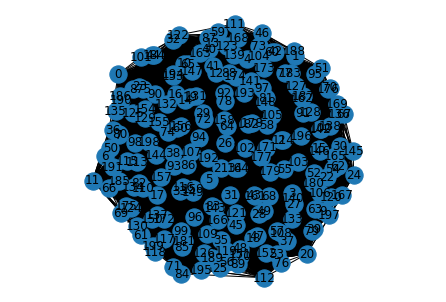

In [16]:
def nx_init_graph(gsize):
    graph = nx.erdos_renyi_graph(gsize, 0.5)
    return nx.to_numpy_matrix(graph)
       
def show_graph(adj_matrix):
    graph = nx.from_numpy_matrix(adj_matrix)
    nx.draw(graph, with_labels=True)
    plt.axis('equal')
    
def import_graph(filepath):
    graph = None
    f = open(filepath, 'r')
    lines = f.readlines()
    for i in lines:
        line = i.strip('\n').split(' ')
        if line[0] == 'p':
            graph = np.zeros((int(line[2]), int(line[2])), dtype = int)
        elif line[0] == 'e':
            graph[int(line[1])-1][int(line[2])-1] = 1
            
    return graph
        
graph = import_graph('DIMACS_all_ascii/brock200_1.clq')
show_graph(graph)